# Importing Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import warnings
import glob
import imageio
import os
import re
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Preprocessed the data

In [6]:
file_path_train = r'/home/shoaib/Programming/Project/data'

In [4]:
# function to find the folders of training or test


def find_folders(path,search,csv=False):
    list_of_folders = []
    
    if csv==False:
        for i in os.listdir(path):
            training_folder_ptr = re.search(search,i)                     # search for pattern
            if training_folder_ptr != None:                               # if pattern matches
                if i.endswith('.csv') != True:                            # grabs only the non csv string
                    list_of_folders.append(os.path.join(path,i))          # join and create the path
    else:
        for i in os.listdir(path):
            training_folder_ptr = re.search(search,i)
            if training_folder_ptr != None:
                if i.endswith('.csv') == True:
                    list_of_folders.append(os.path.join(path,i))
    return list_of_folders

In [8]:
training_image_file_path_list = find_folders(file_path_train,r'training')
training_csv_file_path_list = find_folders(file_path_train,r'training',csv=True)

In [9]:
training_image_file_path_list

['/home/shoaib/Programming/Project/data/training-e',
 '/home/shoaib/Programming/Project/data/training-b',
 '/home/shoaib/Programming/Project/data/training-a',
 '/home/shoaib/Programming/Project/data/training-d',
 '/home/shoaib/Programming/Project/data/training-c']

In [10]:
training_csv_file_path_list

['/home/shoaib/Programming/Project/data/training-b.csv',
 '/home/shoaib/Programming/Project/data/training-e.csv',
 '/home/shoaib/Programming/Project/data/training-a.csv',
 '/home/shoaib/Programming/Project/data/training-d.csv',
 '/home/shoaib/Programming/Project/data/training-c.csv']

In [11]:
# create a function to convert the image into np array

def grab_all_img(list_of_folders):
    
    all_img_path = []
    all_img_name = []
    for i in range(len(list_of_folders)):
        img_list = glob.glob(list_of_folders[i]+'/*.png')
        all_img_path.extend(img_list)
    
    for i in range(len(all_img_path)):
        all_img_name.append(all_img_path[i].split(sep=os.sep)[-1])   # splitting abc/12av.png into abc,12av.png and -1 return last index value
    
    return all_img_path,all_img_name

In [13]:
traininig_image_path,training_img_name = grab_all_img(training_image_file_path_list)

In [14]:
len(traininig_image_path)

72045

In [15]:
# create a class which will have np data and label

class image_data():
    
    def __init__(self,image,label=None):
        self.image = image
        self.label = label
    
    def get_image(self):
        return self.image
    def get_label(self):
        return self.label

In [16]:
# function to get the labels

def get_img_label(file_path_list,image_name_list):
    df_list = []
    for i in range(len(file_path_list)):
        df = pd.read_csv(file_path_list[i])
        df_list.append(df)
    
    # concat the dataframe
    all_df = pd.concat(df_list,ignore_index=True)
    all_df = all_df.set_index('filename') # changing the index to the filename
    
    y_label = []
    
    # get the labels
    
    for i in range(len(image_name_list)):
        label = all_df.loc[image_name_list[i]]['digit']
        y_label.append(label)
    return y_label

In [17]:
train_image_label = get_img_label(file_path_list=training_csv_file_path_list,image_name_list=training_img_name)

In [18]:
def img_to_obj(image_path_list,image_label_list=None):
    
    img_obj_list = []
    # read the image for training dataset
    if image_label_list != None:
        for i in range(len(image_path_list)):
            img = cv.imread(image_path_list[i],cv.IMREAD_GRAYSCALE)  # read the image in grayscale
            label = image_label_list[i]

            # creating a new obj
            obj = image_data(image=img,label=label)
            img_obj_list.append(obj)

            print('Training Image processed {}/{}'.format(i+1,len(image_path_list)),end='\r')
        return img_obj_list
    else:
        for i in range(len(image_path_list)):
            img = cv.imread(image_path_list[i],cv.IMREAD_GRAYSCALE)  # read the image in grayscale
            # creating a new obj
            obj = image_data(image=img)
            img_obj_list.append(obj)
            
            print('Test Image processed {}/{}'.format(i+1,len(image_path_list)),end='\r')
        return img_obj_list

In [19]:
training_img_as_obj_list = img_to_obj(traininig_image_path,train_image_label)

In [20]:
type(training_img_as_obj_list[5].get_image())

numpy.ndarray

# Image Filtering

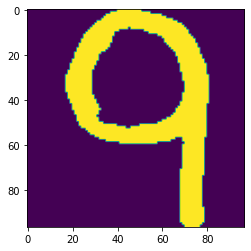

In [17]:
plt.imshow(training_img_as_obj_list[5].get_image())

**Resizing the image**

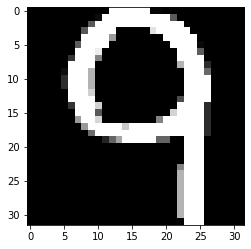

In [26]:
img = training_img_as_obj_list[5].get_image()
img = cv.resize(img,(32,32))
plt.imshow(img,cmap=plt.get_cmap('gray'))

**Applying Gaussian Blur**

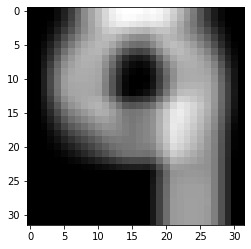

In [27]:
im_g = cv.GaussianBlur(img,(9,9),10)
plt.imshow(im_g,cmap=plt.get_cmap('gray'))

**Applying addWeighted method**

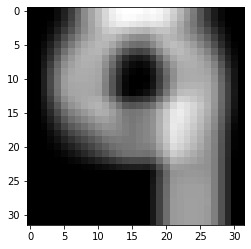

In [30]:
im_w = cv.addWeighted(im_g, 1.5, im_g, -0.5, 0,im)
plt.imshow(im_w,cmap=plt.get_cmap('gray'))

**Applying the kernel method**

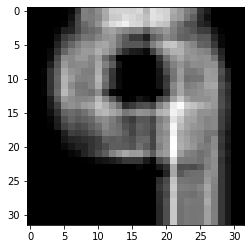

In [34]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
im_k = cv.filter2D(im_w, -1, kernel)
plt.imshow(im_k,cmap=plt.get_cmap('gray'))

# Function for filtering

In [65]:
# function to resize and convert it into numpy array

def fillter_img(image_obj_list,img_size):
    
    img_np = []
    for i in range(len(image_obj_list)):
        img = cv.resize(image_obj_list[i].get_image(),(img_size,img_size))    
        img_guass = cv.GaussianBlur(img,(9,9),10)          # will denoise it
        img_weighted = cv.addWeighted(img, 1.5, img_guass, -0.5, 0,img)  # combining the image with guassian blur
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv.filter2D(img_weighted, -1, kernel)  # filter apply
        
        img = img.reshape(img_size,img_size,1).astype('float32')         # reshape the numpy array taking only one color channel
        
        img_np.append(img)
        
        
        # for printing
        print('processed {}/{}'.format(i+1,len(image_obj_list)),end='\r')
    
    img_np = np.array(img_np)
    return img_np

In [66]:
X_train = fillter_img(training_img_as_obj_list,32)

In [46]:
y_train = np.array([training_img_as_obj_list[i].get_label() for i in range(len(training_img_as_obj_list))])

In [47]:
y_train.shape

(72045,)

# Normalize the data and train validation split

In [68]:
X_train /= 255

In [85]:
# split the data into 2 sets training and validation set

# randomize the index
indices  = list(range(len(X_train)))
np.random.seed(42)
np.random.shuffle(indices)

ind = int(len(indices)*.8)  # 80% data will be Training


# training data
X_train_img = X_train[indices[:ind]]   # will continue till ind(80%) of the indices list where index is randomized
y_train_label = y_train[indices[:ind]]

# validation set
X_val_img = X_train[indices[-(len(indices)-ind):]]
y_val_label = y_train[indices[-(len(indices)-ind):]]


# indicies[-(len(indices)-ind):]--> len(indices)(100)-ind(80) = 20_--> indices[-20:] --> start from the 80th position

In [86]:
X_train_img.shape

(57636, 32, 32, 1)

In [87]:
X_val_img.shape

(14409, 32, 32, 1)

# Model Building

In [ ]:
# creating the model architechture

def model(img_size=32,channels=1):

    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation='relu',
                                input_shape=(img_size,img_size,channels)))
    model.add(keras.layers.MaxPool2D((2,2),strides=2))

    model.add(keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.MaxPool2D((2,2),strides=2))

    model.add(keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.MaxPool2D((2,2),strides=2))


    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(10,activation='softmax'))


    # model compile

    model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [ ]:
# train the model

batch_size = 64
epoch = 30


model.fit(
    x=X_train_img,
    y=y_train_label,
    epochs=epoch,
    batch_size=batch_size,
)

In [ ]:
# Evaluate Model
model.evaluate(X_val_img,y_val_label)

In [ ]:
# Saving the model

model.save('./base_model_bangla_digit_classification')

In [38]:
# Load Model

model = keras.models.load_model('./base_model_bangla_digit_classification')

In [39]:
# Model Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

# Predicting

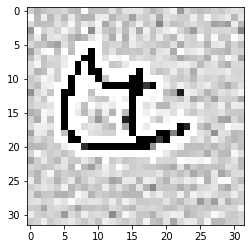

In [40]:
img_path = '/home/shoaib/Programming/Project/data/training-a'
img = os.path.join(img_path,'a00000.png')

img = cv.imread(img,cv.IMREAD_GRAYSCALE)
img = cv.resize(img,(32,32))
img_guass = cv.GaussianBlur(img,(9,9),10)
img_w = cv.addWeighted(img,1.5,img_guass,-0.5,0,img)
kernel= np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
img = cv.filter2D(img_w,-1,kernel)
img = img.reshape(32,32,1).astype('float32')
img /= 255

prediction = model.predict(img.reshape(1,32,32,1))
label =  np.argmax(prediction)

plt.imshow(img.reshape(32,32),cmap=plt.get_cmap('gray'))

In [41]:
label

5